<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/skripsi_cnn_lstm_windowed_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Prediksi Harga Bahan Pangan di Indonesia
import semua library yang dibutuhkan pada awal project, berfungsi untuk mempermudah dalam organisir kode, library yang akan digunakan adalah:

*   `urllib` untuk mengambil data dari url dan menyimpan kembali menjadi format data tertentu
*   `numpy`
*   `pandas` digunakan untuk membaca data dari file ekstention csv dan untuk memnganalisis data
*   `seaborn`
*   `tensorflow` digunakan dalam proses pembuatan model deep learning
*   `matplotlib`merupakan library untuk menamilkan plot dari data 
*   `sklearn` merupakan library untuk modeling data supervised learning dan unsupervised learning, dalam project ini digunakan untuk split data

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## data **generator**

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data) # generate data series menjadi tensor
  add_window_time_step = generate_data.window(time_size+1, shift=1, drop_remainder=True) # membuat data kedalam kolom window yang baru
  flatten_window = add_window_time_step.flat_map(lambda window : window.batch(time_size+1)) # hasil pertambahan step data akan digabung menjadi satu array
  tuple_feature_label = flatten_window.map(lambda window: (window[:-1], window[-1])) # data akan dirubah menjadi feature dan label dengan ketentuan 1 data terakhir sabagai label
  shuffle_data = tuple_feature_label.shuffle(shuffle_data) # data yang sudah jadi akan di random sesuai dengan ukuran random data
  batch_window = shuffle_data.batch(batch_size).prefetch(1) # data akan disusun menjadi batch-batch tertentu sesuai dengan kebutuhan
  
  return batch_window

In [ ]:
def forecast_predict(model, data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

functions *plot value* digunakan untuk menampilkan grafik hasil training model terhadap data, value yang ingin ditampilkan yaitu nilai loss, mape dan mae (disuaikan dengan *metrics *yang digunakan)

In [ ]:
def plot_value(history):
  loss = history.history['loss']
  mape = history.history['mape']
  mae = history.history['mae']
  epoch = range(len(loss))

  plt.plot(epoch, loss, 'r', label='loss')
  plt.plot(epoch, mae, 'y', label='mae')
  plt.legend()
  plt.show()

Function model_evaluate digunakan untuk melihat nilai evaluasi dari model yang telah dibuat berdasarkan data prediksi, model akan dievaluasi berdasarkan nilai mae, mape, dan rmse

In [ ]:
def model_evaluate(data_actual, value_prediction):
  mae = mean_absolute_error(data_actual, value_prediction).numpy()
  mape = mean_absolute_percentage_error(data_actual, value_prediction).numpy()
  mse = mean_squared_error(data_actual, value_prediction).numpy()
  rmse = RootMeanSquaredError(data_actual, value_prediction).numpy()

  print(f"Nilai mae yang didapatkan untuk memprediksi {len(data_actual)} adalah = {mae}\nNilai mape yang diperoleh adalah = {mape}")

## Load Data
Data diambil dari 

In [ ]:
data_url = 'https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_harga_bahan_pangan_indonesia.csv?raw=true'
urllib.request.urlretrieve(data_url, 'data_pangan_indonesia.csv')

('data_pangan_indonesia.csv', <http.client.HTTPMessage at 0x7fedd18d7ad0>)

Read data csv dengan pandas 

In [ ]:
data_pangan = pd.read_csv('data_pangan_indonesia.csv')
data_pangan

,Date,Beras,Beras Kualitas Bawah I (kg),Beras Kualitas Bawah II (kg),Beras Kualitas Medium I (kg),Beras Kualitas Medium II (kg),Beras Kualitas Super I (kg),Beras Kualitas Super II (kg),Daging Ayam,Daging Ayam Ras Segar (kg),...,Cabai Rawit,Cabai Rawit Hijau (kg),Cabai Rawit Merah (kg),Minyak Goreng,Minyak Goreng Curah (kg),Minyak Goreng Kemasan Bermerk 1 (kg),Minyak Goreng Kemasan Bermerk 2 (kg),Gula Pasir,Gula Pasir Kualitas Premium (kg),Gula Pasir Lokal (kg)
0,01/08/2017,11200,10150,9650,11250,11150,12750,12250,34100,34100,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,02/08/2017,11200,10150,9650,11250,11150,12750,12250,34150,34150,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2,03/08/2017,11200,10150,9650,11250,11150,12700,12250,34250,34250,...,40350,34650,46050,13950,12250,15050,14350,14900,16800,13250
3,04/08/2017,11300,10150,10300,11250,11150,12750,12250,34300,34300,...,40500,34600,46550,13950,12200,15050,14350,14900,16800,13250
4,07/08/2017,11200,10150,9650,11250,11150,12750,12250,34350,34350,...,39500,34300,44900,13950,12200,15050,14350,14900,16800,13250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,25/04/2022,11750,10700,10450,11800,11600,13100,12650,38750,38750,...,45500,42750,46900,24600,19700,26950,25950,15350,16000,14800
1170,26/04/2022,11750,10700,10450,11800,11550,13100,12650,39100,39100,...,45500,42550,47100,24600,19600,26950,25900,15350,16000,14850
1171,27/04/2022,11850,10700,10450,11800,11550,13100,13000,39600,39600,...,45750,42800,47750,24650,19700,27050,26000,15350,16000,14850
1172,28/04/2022,11850,10700,10400,11800,11600,13100,13000,40350,40350,...,46050,42500,48250,24600,19650,27050,26000,15350,16000,14850


## Data Understanding
Data yang akan digunakan berjumlah 1174 dengan 32 kolom dengan keterangan:
1. Date : merupakan tanggal proses pengambilan data/sampel data
2. Beras: harga beras secara kumulatif
2. Beras Kualitas Bawah I : data harga beras dengan kualitas bawah 1/pengambilan data berdasarkan harga per-kilogram
3. Beras Kualitas Bawah II : data harga beras dengan kualitas bawah 2/pengambilan data berdasarkan harga per-kilogram
4. Beras Kualitas Medium I (kg) : 
5. Beras Kualitas Medium II 
1. Beras Kualitas Super II (kg)
2. Daging Ayam
3. Daging Ayam Ras Segar
4. Daging Sapi
5. Daging Sapi Kualitas 1
6. Daging Sapi Kualitas 2,
7. Telur Ayam
8. Telur Ayam Ras Segar
9. Bawang Merah
10. Bawang Merah Ukuran Sedang
11. Bawang Putih,
12. Bawang Putih Ukuran Sedang (kg)
13. Cabai Merah
14. Cabai Merah Besar
15. Cabai Merah Keriting
16. Cabai Rawit
17. Cabai Rawit Hijau
18. Cabai Rawit Merah
19. Minyak Goreng
20. Minyak Goreng Curah
21. Minyak Goreng Kemasan Bermerk 1
22. Minyak Goreng Kemasan Bermerk 2
23. Gula Pasir
24. Gula Pasir Kualitas Premium
26. Gula Pasir Lokal



In [ ]:
data_pangan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Date                                  1174 non-null   object
 1   Beras                                 1174 non-null   int64 
 2   Beras Kualitas Bawah I (kg)           1174 non-null   int64 
 3   Beras Kualitas Bawah II (kg)          1174 non-null   int64 
 4   Beras Kualitas Medium I (kg)          1174 non-null   int64 
 5   Beras Kualitas Medium II (kg)         1174 non-null   int64 
 6   Beras Kualitas Super I (kg)           1174 non-null   int64 
 7   Beras Kualitas Super II (kg)          1174 non-null   int64 
 8   Daging Ayam                           1174 non-null   int64 
 9   Daging Ayam Ras Segar (kg)            1174 non-null   int64 
 10  Daging Sapi                           1174 non-null   int64 
 11  Daging Sapi Kualitas 1 (kg)   

In [ ]:
print(f'jumlah data {len(data_pangan)}')
print(f'ukuran dari data {data_pangan.shape}')
data_pangan.columns

jumlah data 1174
ukuran dari data (1174, 32)


Index(['Date', 'Beras', 'Beras Kualitas Bawah I (kg)',
       'Beras Kualitas Bawah II (kg)', 'Beras Kualitas Medium I (kg)',
       'Beras Kualitas Medium II (kg)', 'Beras Kualitas Super I (kg)',
       'Beras Kualitas Super II (kg)', 'Daging Ayam',
       'Daging Ayam Ras Segar (kg)', 'Daging Sapi',
       'Daging Sapi Kualitas 1 (kg)', 'Daging Sapi Kualitas 2 (kg)',
       'Telur Ayam', 'Telur Ayam Ras Segar(kg)', 'Bawang Merah',
       'Bawang Merah Ukuran Sedang (kg)', 'Bawang Putih',
       'Bawang Putih Ukuran Sedang (kg)', 'Cabai Merah',
       'Cabai Merah Besar (kg)', 'Cabai Merah Keriting  (kg)', 'Cabai Rawit',
       'Cabai Rawit Hijau (kg)', 'Cabai Rawit Merah (kg)', 'Minyak Goreng',
       'Minyak Goreng Curah (kg)', 'Minyak Goreng Kemasan Bermerk 1 (kg)',
       'Minyak Goreng Kemasan Bermerk 2 (kg)', 'Gula Pasir',
       'Gula Pasir Kualitas Premium (kg)', 'Gula Pasir Lokal (kg)'],
      dtype='object')

## EDA

## Data Processing
setelah di pahami dan di visualisasi ternyata data memiliki nama kolom yang sulit dimengerti maka diperlukan, pergantian nama kolom seperti (kg) dihapus, huruf upper(besar/kapital) diganti lower(kecil) supaya lebih seragam, spasi diganti dengan underscore(_), bertujuan untuk memudahkan pemanggilan kolom untuk langkah selanjutnya

In [ ]:
data_pangan.columns = data_pangan.columns.str.replace(' (kg)', '', regex=False).str.replace('(kg)', '', regex=False).str.replace(' ', '_').str.lower()
data_pangan

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam,daging_ayam_ras_segar,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,01/08/2017,11200,10150,9650,11250,11150,12750,12250,34100,34100,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,02/08/2017,11200,10150,9650,11250,11150,12750,12250,34150,34150,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
2,03/08/2017,11200,10150,9650,11250,11150,12700,12250,34250,34250,...,40350,34650,46050,13950,12250,15050,14350,14900,16800,13250
3,04/08/2017,11300,10150,10300,11250,11150,12750,12250,34300,34300,...,40500,34600,46550,13950,12200,15050,14350,14900,16800,13250
4,07/08/2017,11200,10150,9650,11250,11150,12750,12250,34350,34350,...,39500,34300,44900,13950,12200,15050,14350,14900,16800,13250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,25/04/2022,11750,10700,10450,11800,11600,13100,12650,38750,38750,...,45500,42750,46900,24600,19700,26950,25950,15350,16000,14800
1170,26/04/2022,11750,10700,10450,11800,11550,13100,12650,39100,39100,...,45500,42550,47100,24600,19600,26950,25900,15350,16000,14850
1171,27/04/2022,11850,10700,10450,11800,11550,13100,13000,39600,39600,...,45750,42800,47750,24650,19700,27050,26000,15350,16000,14850
1172,28/04/2022,11850,10700,10400,11800,11600,13100,13000,40350,40350,...,46050,42500,48250,24600,19650,27050,26000,15350,16000,14850


In [ ]:
data_pangan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   date                             1174 non-null   object
 1   beras                            1174 non-null   int64 
 2   beras_kualitas_bawah_i           1174 non-null   int64 
 3   beras_kualitas_bawah_ii          1174 non-null   int64 
 4   beras_kualitas_medium_i          1174 non-null   int64 
 5   beras_kualitas_medium_ii         1174 non-null   int64 
 6   beras_kualitas_super_i           1174 non-null   int64 
 7   beras_kualitas_super_ii          1174 non-null   int64 
 8   daging_ayam                      1174 non-null   int64 
 9   daging_ayam_ras_segar            1174 non-null   int64 
 10  daging_sapi                      1174 non-null   int64 
 11  daging_sapi_kualitas_1           1174 non-null   int64 
 12  daging_sapi_kualitas_2           1

In [ ]:
beras = data_pangan['beras'].values
beras_kualitas_bawah_i = data_pangan.beras_kualitas_bawah_i.values
beras_kualitas_bawah_ii = data_pangan.beras_kualitas_bawah_ii.values
beras_kualitas_medium_i = data_pangan.beras_kualitas_medium_i.values
beras_kualitas_medium_ii = data_pangan.beras_kualitas_medium_ii.values
beras_kualitas_super_i = data_pangan.beras_kualitas_super_i.values
beras_kualitas_super_ii = data_pangan.beras_kualitas_super_ii.values

daging_ayam = data_pangan.daging_ayam.values
daging_ayam_ras_segar = data_pangan.daging_ayam_ras_segar.values

daging_sapi = data_pangan.daging_sapi.values
daging_sapi_kualitas_1 = data_pangan.daging_sapi_kualitas_1.values
daging_sapi_kualitas_2 = data_pangan.daging_sapi_kualitas_2.values

telur_ayam = data_pangan.telur_ayam.values
telur_ayam_ras_segar = data_pangan.telur_ayam_ras_segar.values

bawang_merah = data_pangan.bawang_merah.values
bawang_merah_ukuran_sedang = data_pangan.bawang_merah_ukuran_sedang.values

bawang_putih = data_pangan.bawang_putih.values
bawang_putih_ukuran_sedang = data_pangan.bawang_putih_ukuran_sedang.values

cabai_merah = data_pangan.cabai_merah.values
cabai_merah_besar = data_pangan.cabai_merah_besar.values
cabai_merah_keriting = data_pangan.cabai_merah_keriting_.values

cabai_rawit = data_pangan.cabai_rawit.values
cabai_rawit_hijau = data_pangan.cabai_rawit_hijau.values
cabai_rawit_merah = data_pangan.cabai_rawit_merah.values

minyak_goreng = data_pangan.minyak_goreng.values
minyak_goreng_curah = data_pangan.minyak_goreng_curah.values
minyak_goreng_kemasan_bermerk_1 = data_pangan.minyak_goreng_kemasan_bermerk_1.values
minyak_goreng_kemasan_bermerk_2 = data_pangan.minyak_goreng_kemasan_bermerk_2.values

gula_pasir = data_pangan.gula_pasir.values
gula_pasir_kualitas_premium = data_pangan.gula_pasir_kualitas_premium.values
gula_pasir_lokal = data_pangan.gula_pasir_lokal.values
date = data_pangan['date'].values

### MinMaxScaller

In [ ]:
scaller = MinMaxScaler(feature_range=(0, 1))

data_beras = scaller.fit_transform(beras.reshape(-1, 1))
data_beras_kualitas_bawah_i = scaller.fit_transform(beras_kualitas_bawah_i.reshape(-1, 1))
data_beras_kualitas_bawah_ii = scaller.fit_transform(beras_kualitas_bawah_ii.reshape(-1, 1))
data_beras_kualitas_medium_i = scaller.fit_transform(beras_kualitas_medium_i.reshape(-1, 1))
data_beras_kualitas_medium_ii = scaller.fit_transform(beras_kualitas_medium_ii.reshape(-1, 1))
data_beras_kualitas_super_i = scaller.fit_transform(beras_kualitas_super_i.reshape(-1, 1))
data_beras_kualitas_super_ii = scaller.fit_transform(beras_kualitas_super_ii.reshape(-1, 1))

data_daging_ayam = scaller.fit_transform(daging_ayam.reshape(-1, 1))
data_daging_ayam_ras_segar = scaller.fit_transform(daging_ayam_ras_segar.reshape(-1, 1))

data_daging_sapi= scaller.fit_transform(daging_sapi.reshape(-1, 1))
data_daging_sapi_kualitas_1 = scaller.fit_transform(daging_sapi_kualitas_1.reshape(-1, 1))
data_daging_sapi_kualitas_2 = scaller.fit_transform(daging_sapi_kualitas_2.reshape(-1, 1))

data_telur_ayam = scaller.fit_transform(beras_kualitas_bawah_i.reshape(-1, 1))
data_telur_ayam_ras_segar = scaller.fit_transform(beras_kualitas_bawah_i.reshape(-1, 1))

data_bawang_merah = scaller.fit_transform(bawang_merah.reshape(-1, 1))
data_bawang_merah_ukuran_sedang = scaller.fit_transform(bawang_merah_ukuran_sedang.reshape(-1, 1))

data_bawang_putih = scaller.fit_transform(bawang_putih.reshape(-1, 1))
data_bawang_putih_ukuran_sedang= scaller.fit_transform(bawang_putih_ukuran_sedang.reshape(-1, 1))

data_cabai_merah = scaller.fit_transform(cabai_merah.reshape(-1, 1))
data_cabai_merah_besar = scaller.fit_transform(cabai_merah_besar.reshape(-1, 1))
data_cabai_merah_keriting = scaller.fit_transform(cabai_merah_keriting.reshape(-1, 1))

data_cabai_rawit = scaller.fit_transform(cabai_rawit.reshape(-1, 1))
data_cabai_rawit_hijau = scaller.fit_transform(cabai_rawit_hijau.reshape(-1, 1))
data_cabai_rawit_merah= scaller.fit_transform(cabai_rawit_merah.reshape(-1, 1))

data_minyak_goreng = scaller.fit_transform(minyak_goreng.reshape(-1, 1))
data_minyak_goreng_curah = scaller.fit_transform(minyak_goreng_curah.reshape(-1, 1))
data_minyak_goreng_kemasan_bermerk_1 = scaller.fit_transform(minyak_goreng_kemasan_bermerk_1.reshape(-1, 1))
data_minyak_goreng_kemasan_bermerk_2 = scaller.fit_transform(minyak_goreng_kemasan_bermerk_2.reshape(-1, 1))

data_gula_pasir = scaller.fit_transform(gula_pasir.reshape(-1, 1))
data_gula_pasir_kualitas_premium = scaller.fit_transform(gula_pasir_kualitas_premium.reshape(-1, 1))
data_gula_pasir_lokal = scaller.fit_transform(gula_pasir_lokal.reshape(-1, 1))

## Data Preparation

### Split data

In [ ]:
x_train_beras, x_test_beras, y_train_beras, y_test_beras= train_test_split(
    data_beras, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras, x_val_beras, y_train_beras, y_val_beras = train_test_split(
    x_train_beras, y_train_beras, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_rawit, x_test_cabai_rawit, y_train_cabai_rawit, y_test_cabai_rawit = train_test_split(
    data_cabai_rawit, date, test_size=0.2, random_state=False, shuffle=False)
x_train_cabai_rawit, x_val_cabai_rawit, y_train_cabai_rawit, y_val_cabai_rawit = train_test_split(
    x_train_cabai_rawit, y_train_cabai_rawit, test_size=0.2, random_state=False, shuffle=False)

x_train_beras_kualitas_bawah_i, x_test_beras_kualitas_bawah_i, y_train_beras_kualitas_bawah_i, y_beras_kualitas_bawah_i = train_test_split(
    data_beras_kualitas_bawah_i, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras_kualitas_bawah_i, x_val_beras_kualitas_bawah_i, y_train_beras_kualitas_bawah_i, y_val_beras_kualitas_bawah_i = train_test_split(
    x_train_beras_kualitas_bawah_i, y_train_beras_kualitas_bawah_i, test_size=0.1, random_state=False, shuffle=False)

x_train_beras_kualitas_bawah_ii, x_test_beras_kualitas_bawah_ii, y_train_beras_kualitas_bawah_i, y_test_beras_kualitas_bawah_i= train_test_split(
    data_beras_kualitas_bawah_ii, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras_kualitas_bawah_ii, x_val_beras_kualitas_bawah_ii, y_train_beras_kualitas_bawah_i, y_val_beras_kualitas_bawah_i = train_test_split(
    x_train_beras, y_train_beras, test_size=0.1, random_state=False, shuffle=False)

x_train_beras_kualitas_medium_i, x_test_beras_kualitas_medium_i, y_train_beras_kualitas_medium_i, y_test_beras_kualitas_medium_i = train_test_split(
    data_beras_kualitas_medium_i, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras_kualitas_medium_i, x_val_beras_kualitas_medium_i, y_train_beras_kualitas_medium_i, y_val_beras_kualitas_medium_i  = train_test_split(
    x_train_beras_kualitas_medium_i, y_train_beras_kualitas_medium_i, test_size=0.1, random_state=False, shuffle=False)

x_train_beras_kualitas_medium_ii, x_test_beras_kualitas_medium_ii, y_train_beras_kualitas_medium_ii, y_test_beras_kualitas_medium_ii = train_test_split(
    data_beras_kualitas_medium_i, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras_kualitas_medium_ii, x_val_beras_kualitas_medium_ii, y_train_beras_kualitas_medium_ii, y_val_beras_kualitas_medium_ii = train_test_split(
    x_train_beras_kualitas_medium_ii, y_train_beras_kualitas_medium_ii, test_size=0.1, random_state=False, shuffle=False)

x_train_beras_kualitas_super_i, x_test_beras_kualitas_super_i, y_train_beras_kualitas_super_i, y_test_beras_kualitas_super_i= train_test_split(
    data_beras_kualitas_super_i, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras_kualitas_super_i, x_val_beras_kualitas_super_i, y_train_bberas_kualitas_super_i, y_val_beras_kualitas_super_i = train_test_split(
    x_train_beras_kualitas_super_i, y_train_beras_kualitas_super_i, test_size=0.1, random_state=False, shuffle=False)

x_train_beras_kualitas_super_ii, x_test_beras_kualitas_super_ii, y_train_beras_kualitas_super_ii, y_test_beras_kualitas_super_ii= train_test_split(
    data_beras_kualitas_super_i, date, test_size=0.2, random_state=False, shuffle=False)
x_train_beras_kualitas_super_ii, x_val_beras_kualitas_super_ii, y_train_beras_kualitas_super_ii, y_val_beras_kualitas_super_ii = train_test_split(
    x_train_beras_kualitas_super_ii, y_train_beras_kualitas_super_ii, test_size=0.1, random_state=False, shuffle=False)

x_train_daging_ayam, x_test_daging_ayam, y_train_daging_ayam, y_test_daging_ayam= train_test_split(
    data_daging_ayam, date, test_size=0.2, random_state=False, shuffle=False)
x_train_daging_ayam, x_val_daging_ayam, y_train_daging_ayam, y_val_daging_ayam = train_test_split(
    x_train_daging_ayam, y_train_daging_ayam, test_size=0.1, random_state=False, shuffle=False)

x_train_daging_ayam_ras_segar, x_test_daging_ayam_ras_segar, y_train_daging_ayam_ras_segar, y_test_daging_ayam_ras_segar= train_test_split(
    data_daging_ayam_ras_segar, date, test_size=0.2, random_state=False, shuffle=False)
x_train_daging_ayam_ras_segar, x_val_daging_ayam_ras_segar, y_train_daging_ayam_ras_segar, y_val_daging_ayam_ras_segar = train_test_split(
    x_train_daging_ayam_ras_segar, y_train_daging_ayam_ras_segar, test_size=0.1, random_state=False, shuffle=False)

x_train_bawang_merah, x_test_bawang_merah, y_train_bawang_merah, y_test_bawang_merah= train_test_split(
    data_bawang_merah, date, test_size=0.2, random_state=False, shuffle=False)
x_train_bawang_merah, x_val_bawang_merah, y_train_bawang_merah, y_val_bawang_merah = train_test_split(
    x_train_bawang_merah, y_train_bawang_merah, test_size=0.1, random_state=False, shuffle=False)

x_train_bawang_merah_ukuran_sedang, x_test_bawang_merah_ukuran_sedang, y_train_bawang_merah_ukuran_sedang, y_test_bawang_merah_ukuran_sedang= train_test_split(
    data_bawang_merah_ukuran_sedang, date, test_size=0.2, random_state=False, shuffle=False)
x_train_bawang_merah_ukuran_sedang, x_val_bawang_merah_ukuran_sedang, y_train_bawang_merah_ukuran_sedang, y_val_bawang_merah_ukuran_sedang = train_test_split(
    x_train_bawang_merah_ukuran_sedang, y_train_bawang_merah_ukuran_sedang, test_size=0.1, random_state=False, shuffle=False)

x_train_bawang_putih, x_test_bawang_putih, y_train_bawang_putih, y_test_bawang_putih= train_test_split(
    data_bawang_putih, date, test_size=0.2, random_state=False, shuffle=False)
x_train_bawang_putih, x_val_bawang_putih, y_train_bawang_putih, y_val_bawang_putih= train_test_split(
    x_train_bawang_putih, y_train_bawang_putih, test_size=0.1, random_state=False, shuffle=False)

x_train_bawang_putih_ukuran_sedang, x_test_bawang_putih_ukuran_sedang, y_train_bawang_putih_ukuran_sedang, y_test_bawang_putih_ukuran_sedang = train_test_split(
    data_bawang_putih_ukuran_sedang, date, test_size=0.2, random_state=False, shuffle=False)
x_train_bawang_putih_ukuran_sedang, x_val_bawang_putih_ukuran_sedang, y_train_bawang_putih_ukuran_sedang, y_val_bawang_putih_ukuran_sedang = train_test_split(
    x_train_bawang_putih_ukuran_sedang, y_train_bawang_putih_ukuran_sedang, test_size=0.1, random_state=False, shuffle=False)

x_train_daging_sapi, x_test_daging_sapi, y_train_daging_sapi, y_test_daging_sapi= train_test_split(
    data_daging_sapi, date, test_size=0.2, random_state=False, shuffle=False)
x_train_daging_sapi, x_val_daging_sapi, y_train_daging_sapi, y_val_daging_sapi = train_test_split(
    x_train_daging_sapi, y_train_daging_sapi, test_size=0.1, random_state=False, shuffle=False)

x_train_daging_sapi_kualitas_1, x_test_daging_sapi_kualitas_1, y_train_daging_sapi_kualitas_1, y_test_daging_sapi_kualitas_1 = train_test_split(
    data_daging_sapi_kualitas_1, date, test_size=0.2, random_state=False, shuffle=False)
x_train_daging_sapi_kualitas_1, x_val_daging_sapi_kualitas_1, y_train_daging_sapi_kualitas_1, y_val_daging_sapi_kualitas_1 = train_test_split(
    x_train_daging_sapi_kualitas_1, y_train_daging_sapi_kualitas_1, test_size=0.1, random_state=False, shuffle=False)

x_train_daging_sapi_kualitas_2, x_test_daging_sapi_kualitas_2, y_train_daging_sapi_kualitas_2, y_test_daging_sapi_kualitas_2 = train_test_split(
    data_daging_sapi_kualitas_2, date, test_size=0.2, random_state=False, shuffle=False)
x_train_daging_sapi_kualitas_2, x_val_daging_sapi_kualitas_2, y_train_daging_sapi_kualitas_2, y_val_daging_sapi_kualitas_2 = train_test_split(
    x_train_daging_sapi_kualitas_2, y_train_daging_sapi_kualitas_2, test_size=0.1, random_state=False, shuffle=False)

x_train_telur_ayam, x_test_telur_ayam, y_train_telur_ayam, y_test_telur_ayam= train_test_split(
    data_telur_ayam, date, test_size=0.2, random_state=False, shuffle=False)
x_train_telur_ayam, x_val_telur_ayam, y_train_telur_ayam, y_val_telur_ayam = train_test_split(
    x_train_telur_ayam, y_train_telur_ayam, test_size=0.1, random_state=False, shuffle=False)

x_train_telur_ayam_ras_segar, x_test_telur_ayam_ras_segar, y_train_telur_ayam_ras_segar, y_test_telur_ayam_ras_segar= train_test_split(
    data_telur_ayam_ras_segar, date, test_size=0.2, random_state=False, shuffle=False)
x_train_telur_ayam_ras_segar, x_val_telur_ayam_ras_segar, y_train_telur_ayam_ras_segar, y_val_telur_ayam_ras_segar = train_test_split(
    x_train_telur_ayam_ras_segar, y_train_telur_ayam_ras_segar, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_merah, x_test_cabai_merah, y_train_cabai_merah, y_test_cabai_merah= train_test_split(
    data_cabai_merah, date, test_size=0.2, random_state=False, shuffle=False)
x_train_cabai_merah, x_val_cabai_merah, y_train_cabai_merah, y_val_cabai_merah = train_test_split(
    x_train_cabai_merah, y_train_cabai_merah, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_merah_besar, x_test_cabai_merah_besar, y_train_cabai_merah_besar, y_test_cabai_merah_besar= train_test_split(
    data_cabai_merah_besar, date, test_size=0.2, random_state=False, shuffle=False)
x_train_cabai_merah_besar, x_val_cabai_merah_besar, y_train_cabai_merah_besar, y_val_cabai_merah_besar = train_test_split(
    x_train_cabai_merah_besar, y_train_cabai_merah_besar, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_merah_keriting, x_test_cabai_merah_keriting, y_train_cabai_merah_keriting, y_test_cabai_merah_keriting= train_test_split(
    data_cabai_merah_keriting, date, test_size=0.2, random_state=False, shuffle=False)
x_train_cabai_merah_keriting, x_val_cabai_merah_keriting, y_train_cabai_merah_keriting, y_val_cabai_merah_keriting= train_test_split(
    x_train_cabai_merah_keriting, y_train_cabai_merah_keriting, test_size=0.1, random_state=False, shuffle=False)

x_train_minyak_goreng, x_test_minyak_goreng, y_train_minyak_goreng, y_test_minyak_goreng= train_test_split(
    data_minyak_goreng, date, test_size=0.2, random_state=False, shuffle=False)
x_train_minyak_goreng, x_val_minyak_goreng, y_train_minyak_goreng, y_val_minyak_goreng = train_test_split(
    x_train_minyak_goreng, y_train_minyak_goreng, test_size=0.1, random_state=False, shuffle=False)

x_train_minyak_goreng_curah, x_test_minyak_goreng_curah, y_train_minyak_goreng_curah, y_test_minyak_goreng_curah= train_test_split(
    data_minyak_goreng_curah, date, test_size=0.2, random_state=False, shuffle=False)
x_train_minyak_goreng_curah, x_val_minyak_goreng_curah, y_train_minyak_goreng_curah, y_val_minyak_goreng_curah = train_test_split(
    x_train_minyak_goreng_curah, y_train_minyak_goreng_curah, test_size=0.1, random_state=False, shuffle=False)

x_train_minyak_goreng_kemasan_bermerk_1, x_test_minyak_goreng_kemasan_bermerk_1, y_train_minyak_goreng_kemasan_bermerk_1, y_test_minyak_goreng_kemasan_bermerk_1= train_test_split(
    data_minyak_goreng_kemasan_bermerk_1, date, test_size=0.2, random_state=False, shuffle=False)
x_train_minyak_goreng_kemasan_bermerk_1, x_val_minyak_goreng_kemasan_bermerk_1, y_train_minyak_goreng_kemasan_bermerk_1, y_val_minyak_goreng_bermerek_1 = train_test_split(
    x_train_minyak_goreng_kemasan_bermerk_1, y_train_minyak_goreng_kemasan_bermerk_1, test_size=0.1, random_state=False, shuffle=False)

x_train_minyak_goreng_kemasan_bermerk_2, x_test_minyak_goreng_kemasan_bermerk_2, y_train_minyak_goreng_kemasan_bermerk_2, y_test_minyak_goreng_kemasan_bermerk_2= train_test_split(
    data_minyak_goreng_kemasan_bermerk_2, date, test_size=0.2, random_state=False, shuffle=False)
x_train_minyak_goreng_kemasan_bermerk_2, x_val_minyak_goreng_kemasan_bermerk_2, y_train_minyak_goreng_kemasan_bermerk_2, y_val_minyak_goreng_kemasan_bermerk_2 = train_test_split(
    x_train_minyak_goreng_kemasan_bermerk_2, y_train_minyak_goreng_kemasan_bermerk_2, test_size=0.1, random_state=False, shuffle=False)

x_train_gula_pasir, x_test_gula_pasir, y_train_gula_pasir, y_test_gula_pasir= train_test_split(
    data_gula_pasir, date, test_size=0.2, random_state=False, shuffle=False)
x_train_gula_pasir, x_val_gula_pasir, y_train_gula_pasir, y_val_gula_pasir = train_test_split(
    x_train_gula_pasir, y_train_gula_pasir, test_size=0.1, random_state=False, shuffle=False)

x_train_gula_pasir_kualitas_premium , x_test_gula_pasir_kualitas_premium, y_train_gula_pasir_kualitas_premium, y_test_gula_pasir_kualitas_premium= train_test_split(
    data_gula_pasir_kualitas_premium, date, test_size=0.2, random_state=False, shuffle=False)
x_train_gula_pasir_kualitas_premium, x_val_gula_pasir_kualitas_premium, y_train_gula_pasir_kualitas_premium, y_val_gula_pasir_kualitas_premium = train_test_split(
    x_train_gula_pasir_kualitas_premium, y_train_gula_pasir_kualitas_premium, test_size=0.1, random_state=False, shuffle=False)

x_train_gula_pasir_lokal, x_test_gula_pasir_lokal, y_train_gula_pasir_lokal, y_test_gula_pasir_lokal= train_test_split(
    data_gula_pasir_lokal, date, test_size=0.2, random_state=False, shuffle=False)
x_train_gula_pasir_lokal, x_val_gula_pasir_lokal, y_train_gula_pasir_lokal, y_val_gula_pasir_lokal = train_test_split(
    x_train_gula_pasir_lokal, y_train_gula_pasir_lokal, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_rawit_hijau, x_test_cabai_rawit_hijau, y_train_cabai_rawit_hijau, y_test_cabai_rawit_hijau= train_test_split(
    data_cabai_rawit_hijau, date, test_size=0.2, random_state=False, shuffle=False)
x_train_cabai_rawit_hijau, x_val_cabai_rawit_hijau, y_train_cabai_rawit_hijau, y_val_cabai_rawit_hijau = train_test_split(
    x_train_cabai_rawit_hijau, y_train_cabai_rawit_hijau, test_size=0.1, random_state=False, shuffle=False)

x_train_cabai_rawit_merah, x_test_cabai_rawit_merah, y_train_cabai_rawit_merah, y_test_cabai_rawit_merah= train_test_split(
    data_cabai_rawit_merah, date, test_size=0.2, random_state=False, shuffle=False)
x_train_cabai_rawit_merah, x_val_cabai_rawit_merah, y_train_cabai_rawit_merah, y_val_cabai_rawit_merah = train_test_split(
    x_train_cabai_rawit_merah, y_train_cabai_rawit_merah, test_size=0.1, random_state=False, shuffle=False)

In [ ]:
train_beras = time_step_generator(x_train_beras, time_size=100, batch_size=1, shuffle_data=200)
train_beras_kualitas_bawah_i = time_step_generator(x_train_beras_kualitas_bawah_i, time_size=100, batch_size=1, shuffle_data=200)
train_beras_kualitas_bawah_ii = time_step_generator(x_train_beras_kualitas_bawah_ii, time_size=100, batch_size=1, shuffle_data=200)
train_beras_kualitas_medium_i = time_step_generator(x_train_beras_kualitas_medium_i, time_size=100, batch_size=1, shuffle_data=200)
train_beras_kualitas_medium_ii = time_step_generator(x_train_beras_kualitas_medium_ii, time_size=100, batch_size=1, shuffle_data=200)
train_beras_kualitas_super_i = time_step_generator(x_train_beras_kualitas_super_i, time_size=100, batch_size=1, shuffle_data=200)
train_beras_kualitas_super_ii = time_step_generator(x_train_beras_kualitas_super_ii, time_size=100, batch_size=1, shuffle_data=200)

train_daging_ayam = time_step_generator(x_train_daging_ayam, time_size=50, batch_size=1, shuffle_data=200)
train_daging_ayam_ras_segar = time_step_generator(x_train_daging_ayam_ras_segar, time_size=100, batch_size=1, shuffle_data=200)

train_daging_sapi = time_step_generator(x_train_daging_sapi, time_size=100, batch_size=1, shuffle_data=200)
train_daging_sapi_kualitas_1 = time_step_generator(x_train_daging_sapi_kualitas_1, time_size=100, batch_size=1, shuffle_data=200)
train_daging_sapi_kualitas_2 = time_step_generator(x_train_daging_sapi_kualitas_2, time_size=100, batch_size=1, shuffle_data=200)

train_telur_ayam = time_step_generator(x_train_beras, time_size=100, batch_size=1, shuffle_data=200)
train_telur_ayam_ras_segar = time_step_generator(x_train_beras, time_size=100, batch_size=1, shuffle_data=200)

train_bawang_merah = time_step_generator(x_train_bawang_merah, time_size=100, batch_size=1, shuffle_data=200)
train_bawang_merah_ukuran_sedang = time_step_generator(x_train_bawang_merah, time_size=100, batch_size=1, shuffle_data=200)

train_bawang_putih = time_step_generator(x_train_bawang_putih, time_size=100, batch_size=1, shuffle_data=200)
train_bawang_putih_ukuran_sedang = time_step_generator(x_train_bawang_putih_ukuran_sedang, time_size=100, batch_size=1, shuffle_data=200)

train_cabai_merah = time_step_generator(x_train_cabai_merah, time_size=100, batch_size=1, shuffle_data=200)
train_cabai_merah_keriting = time_step_generator(x_train_cabai_merah_keriting, time_size=100, batch_size=1, shuffle_data=200)
train_cabai_merah_besar = time_step_generator(x_train_cabai_merah_besar, time_size=100, batch_size=1, shuffle_data=200)

train_cabai_rawit = time_step_generator(x_train_cabai_rawit, time_size=200, batch_size=1, shuffle_data=200)
train_cabai_rawit_hijau = time_step_generator(x_train_cabai_rawit_hijau, time_size=100, batch_size=1, shuffle_data=200)
train_cabai_rawit_merah = time_step_generator(x_train_cabai_rawit_merah, time_size=100, batch_size=1, shuffle_data=200)

train_minyak_goreng = time_step_generator(x_train_minyak_goreng, time_size=100, batch_size=1, shuffle_data=200)
train_minyak_goreng_curah = time_step_generator(x_train_minyak_goreng_curah, time_size=100, batch_size=1, shuffle_data=200)
train_minyak_goreng_kemasan_bermerek_1 = time_step_generator(x_train_minyak_goreng_kemasan_bermerk_1, time_size=100, batch_size=1, shuffle_data=200)
train_minyak_goreng_kemasan_bermerek_2 = time_step_generator(x_train_minyak_goreng_kemasan_bermerk_2, time_size=100, batch_size=1, shuffle_data=200)

train_gula_pasir = time_step_generator(x_train_gula_pasir, time_size=100, batch_size=1, shuffle_data=200)
train_gula_pasir_kualitas_premium = time_step_generator(x_train_gula_pasir_kualitas_premium, time_size=100, batch_size=1, shuffle_data=200)
train_gula_pasir_lokal = time_step_generator(x_train_gula_pasir_lokal, time_size=100, batch_size=1, shuffle_data=200)

## Modeling

In [ ]:
model= Sequential([
    Conv1D(4, kernel_size=2, activation='relu', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(16),
    Dense(64, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 4)           12        
                                                                 
 lstm (LSTM)                 (None, None, 24)          2784      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2624      
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,573
Trainable params: 6,573
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.Huber(), metrics=['mae', 'mape'])

In [ ]:
history_beras = model.fit(train_beras, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 6.4146e-04 - mae: 0.0148 - mape: 3.1514
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 4.5159e-04 - mae: 0.0110 - mape: 2.2953
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 4.5908e-04 - mae: 0.0115 - mape: 2.4035
Epoch 4/10
745/745 [==============================] - 10s 13ms/step - loss: 4.4265e-04 - mae: 0.0108 - mape: 2.2718
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 4.3673e-04 - mae: 0.0108 - mape: 2.2460
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 4.2726e-04 - mae: 0.0100 - mape: 2.0786
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 4.7603e-04 - mae: 0.0127 - mape: 2.6676
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 4.2462e-04 - mae: 0.0101 - mape: 2.0994
Epoch 9/10
745/745 [==============================] - 6s 8ms/step - loss: 4.3260e-04 -

In [ ]:
history_daging_ayam = model.fit(train_daging_ayam, epochs=10)

Epoch 1/10
795/795 [==============================] - 5s 7ms/step - loss: 0.0015 - mae: 0.0392 - mape: 85691.8906
Epoch 2/10
795/795 [==============================] - 5s 7ms/step - loss: 5.7808e-04 - mae: 0.0237 - mape: 84373.9688
Epoch 3/10
795/795 [==============================] - 5s 7ms/step - loss: 5.4178e-04 - mae: 0.0233 - mape: 56203.3555
Epoch 4/10
795/795 [==============================] - 5s 7ms/step - loss: 5.1708e-04 - mae: 0.0223 - mape: 36447.8945
Epoch 5/10
795/795 [==============================] - 5s 7ms/step - loss: 5.3670e-04 - mae: 0.0223 - mape: 40590.8359
Epoch 6/10
795/795 [==============================] - 5s 7ms/step - loss: 5.0150e-04 - mae: 0.0221 - mape: 61684.6797
Epoch 7/10
795/795 [==============================] - 5s 7ms/step - loss: 5.2937e-04 - mae: 0.0226 - mape: 37572.4219
Epoch 8/10
795/795 [==============================] - 5s 7ms/step - loss: 4.8662e-04 - mae: 0.0209 - mape: 53768.7383
Epoch 9/10
795/795 [==============================] - 5s 7ms

In [ ]:
history_daging_sapi = model.fit(train_daging_sapi, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 5.6281e-04 - mae: 0.0157 - mape: 10.5495
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 4.1533e-04 - mae: 0.0137 - mape: 8.3434
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 3.9637e-04 - mae: 0.0142 - mape: 9.3108
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 3.9196e-04 - mae: 0.0136 - mape: 8.9294
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 3.3490e-04 - mae: 0.0126 - mape: 7.6255
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 3.7604e-04 - mae: 0.0132 - mape: 8.1447
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 3.7135e-04 - mae: 0.0125 - mape: 7.9212
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 3.6687e-04 - mae: 0.0136 - mape: 8.2814
Epoch 9/10
745/745 [==============================] - 6s 8ms/step - loss: 3.3761e-04 - 

In [ ]:
history_telur_ayam = model.fit(train_telur_ayam, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 6.1157e-04 - mae: 0.0151 - mape: 3.1981
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 5.3605e-04 - mae: 0.0140 - mape: 2.9672
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 5.3211e-04 - mae: 0.0140 - mape: 2.9577
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 5.2694e-04 - mae: 0.0143 - mape: 3.0280
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 5.1833e-04 - mae: 0.0130 - mape: 2.7527
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 4.8089e-04 - mae: 0.0122 - mape: 2.5702
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 4.7695e-04 - mae: 0.0122 - mape: 2.5603
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 4.9965e-04 - mae: 0.0131 - mape: 2.7770
Epoch 9/10
745/745 [==============================] - 6s 8ms/step - loss: 5.1272e-04 - m

In [ ]:
history_bawang_putih = model.fit(train_bawang_putih, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 7.2852e-04 - mae: 0.0188 - mape: 80896.7734
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 5.0724e-04 - mae: 0.0133 - mape: 60600.3164
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 4.6244e-04 - mae: 0.0123 - mape: 43259.7109
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 4.6910e-04 - mae: 0.0131 - mape: 29901.4473
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 5.0018e-04 - mae: 0.0129 - mape: 38472.6445
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 4.5809e-04 - mae: 0.0118 - mape: 68325.0156
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 5.0188e-04 - mae: 0.0128 - mape: 73456.7109
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 4.4792e-04 - mae: 0.0114 - mape: 30136.5605
Epoch 9/10
745/745 [==============================] - 6s

In [ ]:
history_bawang_merah = model.fit(train_bawang_merah, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 2.9445e-04 - mae: 0.0124 - mape: 49095.2930
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 2.7738e-04 - mae: 0.0122 - mape: 106985.7422
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 2.4183e-04 - mae: 0.0117 - mape: 69098.5938
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 2.3056e-04 - mae: 0.0105 - mape: 74773.6562
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 2.1068e-04 - mae: 0.0101 - mape: 32245.1348
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 2.5509e-04 - mae: 0.0117 - mape: 45689.9023
Epoch 7/10
745/745 [==============================] - 6s 9ms/step - loss: 2.2085e-04 - mae: 0.0105 - mape: 75887.6484
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 2.1542e-04 - mae: 0.0108 - mape: 48853.9688
Epoch 9/10
745/745 [==============================] - 6

In [ ]:
history_cabai_merah = model.fit(train_cabai_merah, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 9.6858e-04 - mae: 0.0221 - mape: 155590.0000
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 8.6877e-04 - mae: 0.0209 - mape: 176190.5625
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 6.9456e-04 - mae: 0.0186 - mape: 201790.5781
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 6.4431e-04 - mae: 0.0184 - mape: 177031.0156
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 6.5001e-04 - mae: 0.0180 - mape: 174380.5469
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 6.8648e-04 - mae: 0.0187 - mape: 275251.1875
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 5.7020e-04 - mae: 0.0179 - mape: 184162.1406
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 5.6083e-04 - mae: 0.0180 - mape: 194546.0000
Epoch 9/10
745/745 [============================

In [ ]:
history_cabai_rawit = model.fit(train_cabai_rawit, epochs=10)

Epoch 1/10
551/551 [==============================] - 6s 10ms/step - loss: 4.6516e-04 - mae: 0.0167 - mape: 7.7595
Epoch 2/10
551/551 [==============================] - 6s 10ms/step - loss: 4.1474e-04 - mae: 0.0167 - mape: 7.8539
Epoch 3/10
551/551 [==============================] - 6s 10ms/step - loss: 3.7521e-04 - mae: 0.0164 - mape: 7.8466
Epoch 4/10
551/551 [==============================] - 6s 10ms/step - loss: 3.7164e-04 - mae: 0.0171 - mape: 8.0311
Epoch 5/10
551/551 [==============================] - 6s 10ms/step - loss: 3.4168e-04 - mae: 0.0165 - mape: 8.1650
Epoch 6/10
551/551 [==============================] - 6s 10ms/step - loss: 3.3706e-04 - mae: 0.0166 - mape: 8.5706
Epoch 7/10
551/551 [==============================] - 6s 11ms/step - loss: 3.3698e-04 - mae: 0.0166 - mape: 8.2627
Epoch 8/10
551/551 [==============================] - 6s 10ms/step - loss: 3.2779e-04 - mae: 0.0158 - mape: 7.8236
Epoch 9/10
551/551 [==============================] - 6s 10ms/step - loss: 2.940

In [ ]:
history_gula_pasir = model.fit(train_gula_pasir, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 1.3883e-04 - mae: 0.0096 - mape: 284368.9375
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 1.2002e-04 - mae: 0.0090 - mape: 201987.0781
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 1.2931e-04 - mae: 0.0090 - mape: 127219.9531
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 1.3855e-04 - mae: 0.0093 - mape: 174994.0625
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 9.8924e-05 - mae: 0.0080 - mape: 131047.7500
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 1.2676e-04 - mae: 0.0094 - mape: 114752.4531
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 8.2102e-05 - mae: 0.0075 - mape: 143047.1406
Epoch 8/10
745/745 [==============================] - 6s 8ms/step - loss: 1.1530e-04 - mae: 0.0084 - mape: 71079.4453
Epoch 9/10
745/745 [=============================

In [ ]:
history_minyak_goreng = model.fit(train_minyak_goreng, epochs=10)

Epoch 1/10
745/745 [==============================] - 6s 8ms/step - loss: 6.0570e-05 - mae: 0.0055 - mape: 45755.7383
Epoch 2/10
745/745 [==============================] - 6s 8ms/step - loss: 5.1501e-05 - mae: 0.0055 - mape: 42408.1406
Epoch 3/10
745/745 [==============================] - 6s 8ms/step - loss: 4.6182e-05 - mae: 0.0052 - mape: 38336.4688
Epoch 4/10
745/745 [==============================] - 6s 8ms/step - loss: 5.1715e-05 - mae: 0.0056 - mape: 38648.5781
Epoch 5/10
745/745 [==============================] - 6s 8ms/step - loss: 4.4937e-05 - mae: 0.0048 - mape: 20399.0371
Epoch 6/10
745/745 [==============================] - 6s 8ms/step - loss: 4.3003e-05 - mae: 0.0047 - mape: 39476.3906
Epoch 7/10
745/745 [==============================] - 6s 8ms/step - loss: 3.9157e-05 - mae: 0.0043 - mape: 47929.1367
Epoch 8/10
745/745 [==============================] - 6s 9ms/step - loss: 4.1331e-05 - mae: 0.0044 - mape: 45372.6445
Epoch 9/10
745/745 [==============================] - 6s

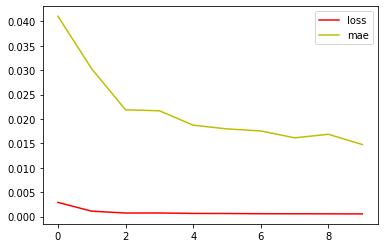

In [ ]:
plot_value(history_beras)

## Evaluation

In [ ]:
prediction = forecast_predict(model, x_test_daging_ayam, time_size=5, batch_size=1, shuffle_data=100)
prediction.shape

(231, 1)

In [ ]:
result = prediction.squeeze()
results = result.reshape(-1, 1)
results = scaller.inverse_transform(results)
results = results.reshape(-1)
results.shape

(231,)

In [ ]:
data_test = x_test_daging_ayam[:-4]
data_test = data_test.reshape(-1)
# data_test

In [ ]:
data_new = pd.DataFrame()
data_new['actual'] = data_test
data_new['prediction'] = result
data_new

,actual,prediction
0,0.698842,0.401957
1,0.691120,0.406603
2,0.679537,0.409144
3,0.667954,0.412330
4,0.667954,0.410830
...,...,...
226,0.706564,0.363781
227,0.714286,0.329893
228,0.714286,0.296443
229,0.733591,0.266016


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mean_absolute_percentage_error(data_test, result), mean_absolute_error(data_test, result)

(0.29561451391549276, 0.17774647833885393)

In [ ]:
mae = mean_absolute_error(data_test, result)
mape = mean_absolute_percentage_error(data_test, result)
mae, mape

(0.17774647833885393, 0.29561451391549276)

In [ ]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.4 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
tested = pd.read_excel('tested.xlsx', skiprows=8)
tested = tested.drop('No.', axis=1)
tested = tested.T.reset_index()
tested.columns = tested.loc[0]
tested = tested.drop(0)
tested = tested.rename(columns={'Komoditas(Rp)': 'Date'})
tested

FileNotFoundError: ignored

In [ ]:
test_beras = tested['Daging Ayam'].values
minmaxtest = scaller.fit_transform(test_beras.reshape(-1, 1))
prediction_1 = forecast_predict(model, minmaxtest, time_size=2, batch_size=1, shuffle_data=1000)
result_1 = prediction_1.squeeze()
result_1.shape

In [ ]:
result_1, minmaxtest

In [ ]:
results_1 = result_1.reshape(-1, 1)
results_1 = scaller.inverse_transform(results_1).round(1)
results_1 = results_1.reshape(-1)
results_1.shape

In [ ]:
test_berass = test_beras[:-1]
date = tested['Date']
date = date[:-1]
new = pd.DataFrame()
new['date'] = date
new['actual'] = test_berass
new['prediction'] = results_1.round()
new

In [ ]:
minn = minmaxtest.reshape(-1)
minn = minn[:-1]

testt = test_beras[:-1]
mae = mean_absolute_error(minn, result_1)
mape = mean_absolute_percentage_error(testt, results_1)
mae, mape

In [ ]:
tessss = testt.reshape(-1, 1, 1)
res = results.reshape(-1, 1, 1)
tessss.shape

In [ ]:
mae = mean_absolute_error(minn, result_1)
# mape = mean_absolute_percentage_error(tessss, res)
# mae, mape

## Implementation

In [ ]:
predict_list = []

batch = x_train_beras[-10:].reshape((1, 10, 1))
print('ini',batch)
for i in range(10):
  predict_list.append(model.predict(batch)[0])
  batch = np.append(batch[:, 1:, :], [[predict_list[i]]], axis=1)
  print('baru', batch)
  print(predict_list)

add_dates = []

predicted = pd.DataFrame(predict_list, 
                         columns=['prediction'])

predicted['date'] = y_train_beras[-10:]
predicted['actual'] = x_train_beras[-10:]

ini [[[0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]]]
baru [[[0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.47055548]]]
[array([0.47055548], dtype=float32)]
baru [[[0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.47055548]
  [0.4766207 ]]]
[array([0.47055548], dtype=float32), array([0.4766207], dtype=float32)]
baru [[[0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.47055548]
  [0.4766207 ]
  [0.48166379]]]
[array([0.47055548], dtype=float32), array([0.4766207], dtype=float32), array([0.4816638], dtype=float32)]
baru [[[0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.45833333]
  [0.47055548]
  [0.4766207 ]
  [0.48166379]
  [0.48618558]]]


In [ ]:
predicted

,prediction,date,actual
0,0.470555,15/12/2020,0.458333
1,0.476621,16/12/2020,0.458333
2,0.481664,17/12/2020,0.458333
3,0.486186,18/12/2020,0.458333
4,0.489877,21/12/2020,0.458333
5,0.494158,22/12/2020,0.458333
6,0.498254,23/12/2020,0.458333
7,0.502950,28/12/2020,0.458333
8,0.507663,29/12/2020,0.458333
9,0.512657,30/12/2020,0.458333


In [ ]:
mean_absolute_percentage_error(x_train_beras[-10:], predict_list)

0.07358230027285559

# predicted